# MS4610 Introduction to Data Analytics || Course Project 
### Model Selection and Hyperparameter Tuning
Notebook by **Group 12**

Using cleaned data, this notebook attempts to find the model that best predicts chances of payment default. We look at model performances without any feature engineering (baseline) and the same when sufficient feature engineering has been performed. The following operations have been performed:

1. Baseline performance using gradient boosted models. 

In [6]:
# Data handling libraries

import numpy as np
import pandas as pd

# Classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

# Plotting libraries

import matplotlib.pyplot as plt

In [3]:
# Import dataset

train = pd.read_csv(".././mod_data/train.csv")

## Useful Functions
The functions below will be used to track the model's performance, which will assist us in hyperparameter tuning. The following functions are available:
1. **learn_progress**: Plots trends of training and cross-validation score against %age data learned

In [17]:
def learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2):
    """
    Plots learning curves for training and cross-validation for input model and dataset
    as a function of fraction of data the model has trained on.
    
    :param model: (scikit-learn model-like) The model which is being trained on the data
    :param X: (numpy array-like) Training features
    :param y: (numpy array-like) Target values for prediction
    :param res: (integer) Number of points on which progress is calculated (default = 5)
    :param scoring: (scikit-learn SCORER string) Parameter indicating learning progress.
                    Scorer options can be accessed using sklearn.metrics.SCORERS.keys()
                    (default = 'roc_auc')
    :param cv: Number of cross-validation folds (default = 2)
    
    :return:
        Renders a matplotlib pyplot object of with line plots of training and validation 
        scores.
    """
    train_sizes = np.linspace(0.1, 1, res)
    _, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes,
                                                   scoring=scoring, cv=cv)
    
    fig, ax = plt.subplots()
    plt.grid()
    
    plt.plot(train_scores.mean(axis=1), marker='o', c='blue', alpha=0.7)
    plt.plot(valid_scores.mean(axis=1), marker='o', c='red', alpha=0.7)
    
    plt.title('Learning progress')
    plt.ylabel('Score')
    plt.xlabel('Progress')
    plt.xticks([i for i in range(res)], np.linspace(0.1, 1, res))
    plt.legend(['Training score', 'Validation score'])

    plt.show()

## Baseline Model Performance
In this section, we check the performance of **gradient boosted decision-tree models** on the dataset without any feature engineering or hyperparameter tuning. This will provide a benchmark to improve upon as we modify/generate/discard features from the dataset. The models below were chosen as they can internally handle missing values. The following models have been tested.
1. XGBoost Classifier
2. LightGBM Classifier

ROC-AUC Score: 0.7102340363028603

              precision    recall  f1-score   support

           0       0.84      0.78      0.81     11829
           1       0.54      0.64      0.59      4771

    accuracy                           0.74     16600
   macro avg       0.69      0.71      0.70     16600
weighted avg       0.76      0.74      0.75     16600



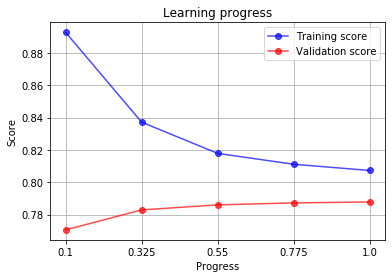

In [18]:
# XGBoost Classifier

# Label encoding card_type column
le = LabelEncoder()
train['card_type'] = le.fit_transform(train.card_type)

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.03,
                      objective='binary:logistic',
                      scale_pos_weight=2,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.7014957290059375

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     11829
           1       0.56      0.59      0.57      4771

    accuracy                           0.75     16600
   macro avg       0.70      0.70      0.70     16600
weighted avg       0.75      0.75      0.75     16600



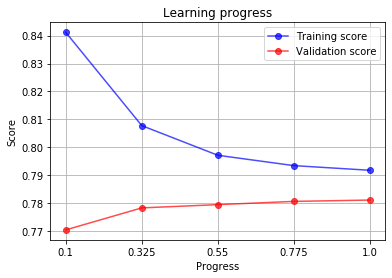

In [19]:
# LightGBM Classifier

# Label encoding card_type column
le = LabelEncoder()
train['card_type'] = le.fit_transform(train.card_type)

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=200,
                       max_depth=4,
                       learning_rate=0.01, 
                       objective='binary',
                       scale_pos_weight=2,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 